# Voice Emotion Detector

## By: Ibrahim Noman

## This is the python notebook used to create the voice emotion detection pytorch model. In this notebook:



*   Data will be preprocessed
*   Pytorch model will be created
*   Data will be trained and validated



# Importing libraries

## The following libraries will be used.

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import torch

# Loading audio

## The [RAVDESS Data Set](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/code) from Kaggle will be used to train the model.

## This data set contains 60 trials for 24 actors (1440 observations). Speech emotions include neutral, calm, happy, sad, angry, fearful, surprise, and disgust expressions.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


# Preprocessing Audio

## There are various preprocessing steps that need to be handled. First, there needs to be an emotion mapping for the emotions. These numeric mappings are the second number in the file name.

## Next, the file name is consolidated into a dataframe as well as the emotion label, the numeric code and the actor.

In [ ]:
# Define base path to the dataset
path = "/kaggle/input/ravdess-emotional-speech-audio"

# Emotion labels as per RAVDESS documentation
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Store metadata
data = []

# Traverse each actor folder
for actor_folder in os.listdir(path):
    actor_path = os.path.join(path, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    # Traverse each file
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            parts = file.split('-')
            emotion_code = parts[2]
            emotion_label = emotion_map.get(emotion_code, "unknown")

            file_path = os.path.join(actor_path, file)
            data.append({
                "file_path": file_path,
                "emotion_code": emotion_code,
                "emotion_label": emotion_label,
                "actor": actor_folder
            })

# Convert to DataFrame
df = pd.DataFrame(data)
df.head()

,file_path,emotion_code,emotion_label,actor
0,/kaggle/input/ravdess-emotional-speech-audio/A...,08,surprised,Actor_02
1,/kaggle/input/ravdess-emotional-speech-audio/A...,01,neutral,Actor_02
2,/kaggle/input/ravdess-emotional-speech-audio/A...,07,disgust,Actor_02
3,/kaggle/input/ravdess-emotional-speech-audio/A...,07,disgust,Actor_02
4,/kaggle/input/ravdess-emotional-speech-audio/A...,01,neutral,Actor_02


## Next, a preprocessing function is created using the `librosa` library. This function does the following:

* Trims audio (removes leading/trailing silence)
* Padding audio if shorter than 3 seconds (ensures uniform length)
* Resamples audio to 16 kHz
* Extracts MFCCs (commonly used for speech recognition tasks)

## This function is applied to all the file paths in ther `df` dataset.


In [ ]:
# Preprocessing function
def preprocess_audio(file_path):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=16000)

    # Trim audio (remove leading/trailing silence)
    audio, _ = librosa.effects.trim(audio, top_db=20)

    # Pad to 3 seconds (if shorter)
    if len(audio) < 3 * sr:
        padding = 3 * sr - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')

    # Resample to 16kHz (if needed)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)

    # Optionally extract Mel spectrogram
    # melspectrogram = librosa.feature.melspectrogram(y=audio, sr=16000)

    # Return the MFCC features (or mel spectrogram, based on your preference)
    return mfccs.T  # Transpose so that shape is [time_steps, n_mfcc] (better for models)

# Apply preprocessing function to df
df['audio'] = df['file_path'].apply(preprocess_audio)

# Model Development

## In this section, the emotion labels are converted into tensors for Pytorch.

In [ ]:
import torch.nn.functional as F

# Map emotion labels (strings) to integers
emotion_mapping = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

# Convert the emotion labels to integers
df['emotion_label'] = df['emotion_label'].map(emotion_mapping)

# Now convert to a tensor
emotion_tensor = torch.tensor(df['emotion_label'].tolist(), dtype=torch.long)

# Max length of sequences (e.g., 3 seconds worth of features)
max_len = 150  # Example: 3 seconds worth of MFCCs, assuming 40 MFCCs per time step

# Convert the audio features and pad them to the max length
audio_tensor = []

for audio in df['audio']:
    # Pad or truncate along the time dimension
    if audio.shape[0] < max_len:
        padding = max_len - audio.shape[0]
        audio_padded = np.pad(audio, ((0, padding), (0, 0)), mode='constant')
    else:
        audio_padded = audio[:max_len, :]  # Truncate if too long

    # Convert to torch tensor and append to the list
    audio_tensor.append(torch.tensor(audio_padded, dtype=torch.float32))

# Stack all tensors into a single tensor
audio_tensor = torch.stack(audio_tensor)

# Convert the emotion labels (assumed to be integers)
emotion_tensor = torch.tensor(df['emotion_label'].tolist())

print(audio_tensor.shape)  # Should give (num_samples, max_len, 40)
print(emotion_tensor.shape)  # Should give (num_samples,)

torch.Size([1440, 150, 40])
torch.Size([1440])


# Training and validating

## Pytorch data set is created for training and validation.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(audio_tensor, emotion_tensor, test_size=0.2, random_state=42)

# Pytorch data set
class EmotionDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

# Applying to data
train_dataset  = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## The `EmotionCNN` is created to cclassify 8 emotioons from audio features. It applies two convolutional layers with batch normalization and max pooling to extract temporal patterns, followed by global average and max pooling. The resulting features are concatenated and passed through fully connected layers with dropout for regularization.

In [ ]:
import torch.nn as nn

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.fc1 = nn.Linear(256, 128)  # 128 mean + 128 max
        self.fc2 = nn.Linear(128, 8)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, T, 40) → (B, 40, T)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x_mean = x.mean(dim=2)
        x_max = x.max(dim=2).values
        x = torch.cat((x_mean, x_max), dim=1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Now it is time for the training and validation. An early stopping callback is applied oce validation accuracy reaches 75%.

In [ ]:
import copy

patience = 8
best_val_acc = 0
epochs_no_improve = 0
train_losses = []
val_losses = []
best_model = None

for epoch in range(30):  # train longer
    model.train()
    train_loss = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/30 - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")



    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if best_val_acc >= 0.75:
            print(f"Early stopping! Best validation accuracy reached: {best_val_acc:.4f}")
            break

model.load_state_dict(best_model)

Epoch 1/30 - Loss: 4.5653 - Train Acc: 0.9592 - Val Acc: 0.7431
Epoch 2/30 - Loss: 5.6387 - Train Acc: 0.9479 - Val Acc: 0.7222
Epoch 3/30 - Loss: 7.7036 - Train Acc: 0.9253 - Val Acc: 0.7292
Epoch 4/30 - Loss: 5.0030 - Train Acc: 0.9514 - Val Acc: 0.7361
Epoch 5/30 - Loss: 5.5472 - Train Acc: 0.9470 - Val Acc: 0.7708
Epoch 6/30 - Loss: 5.5567 - Train Acc: 0.9401 - Val Acc: 0.7188
Early stopping! Best validation accuracy reached: 0.7708


<All keys matched successfully>

              precision    recall  f1-score   support

     neutral       0.55      0.58      0.56        19
        calm       0.79      0.93      0.85        40
       happy       0.70      0.68      0.69        41
         sad       0.66      0.66      0.66        35
       angry       0.90      0.82      0.86        34
     fearful       0.72      0.74      0.73        31
     disgust       0.92      0.78      0.84        45
   surprised       0.82      0.86      0.84        43

    accuracy                           0.77       288
   macro avg       0.76      0.76      0.75       288
weighted avg       0.78      0.77      0.77       288



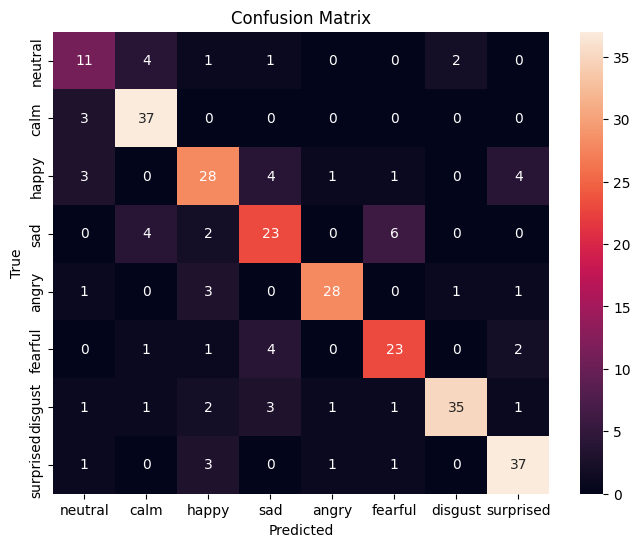

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Report
print(classification_report(all_labels, all_preds, target_names=emotion_mapping.keys()))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=emotion_mapping.keys(), yticklabels=emotion_mapping.keys(), fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Conclusion

## Overall, the model performs very well with 94% training and 77% Validation accuracy. Some things to note:

* Model performs the best for surprised (37/43) and calm (37/40)
* Handles distinct emotions well
* Struggles with overlapping emotions such as neutral and happy or sad and fearful

In [ ]:
# Saving model
torch.save(model.state_dict(), 'emotion_cnn.pth')